In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

# Data Loader

In [3]:
!pip install opendatasets
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: attrsauby
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


100%|██████████| 66.0M/66.0M [00:00<00:00, 561MB/s]

In [ ]:
#df= pd.read_csv('creditcardfraud/creditcard.csv')

V1- V29 --> encrypted transactional behaviour features

Time --> temporal pattern

Amount --> monetary risk

Class --> fraud flag

# EDA

In [5]:
from pandas._libs.interval import VALID_CLOSED
# Class Imbalance Report
def class_imbalance_report(df):
  counts = df['Class'].value_counts()
  ratios = df['Class'].value_counts(normalize=True)

  report = pd.DataFrame({
      'counts': counts,
      'ratios': ratios})
  return report

# Amount Distribution Plot

def plot_amount_dist(df):
  plt.figure(figsize=(10, 5))
  plt.hist(df[df['Class']==0]['Amount'], bins= 100,alpha=0.6, label='Legit')
  plt.hist(df[df['Class']==1]['Amount'], bins= 100,alpha=0.6, label='Fraud')
  plt.yscale("log")
  plt.xlabel('Transaction Amount')
  plt.ylabel('Frequency (log)')
  plt.title('Amount Distribution By Class')
  plt.legend()
  plt.show()

# Time Pattern Plot

def plot_fraud_over_time(df,window=5000):
  df_sort= df.sort_values(by='Time')
  rolling_fraud_rate= df_sort['Class'].rolling(window, min_periods=1).mean()

  plt.figure(figsize=(10,5))
  #plt.plot(df_sort['Time'], rolling_fraud_rate)
  plt.plot(rolling_fraud_rate)
  plt.xlabel('Tansaction Index (Time sorted)')
  plt.ylabel('Rolling Fraud Rate')
  plt.title('Fraud Rate Drift Over Time')
  plt.show()

# KS Seperation Report

def ks_report(df):
  v_cols= [c for c in df.columns if c.startswith('V')]
  ks_results=[]
  for col in v_cols:
    legit= df[df['Class']==0][col]
    fraud= df[df['Class']==1][col]

    ks_stat= ks_2samp(legit, fraud).statistic
    ks_results.append((col, ks_stat))

  ks_df= pd.DataFrame(
      ks_results,
      columns=['feature', 'ks statistic']
  ).sort_values(by='ks statistic', ascending=False)

  return ks_df

# Top Signal Visualisation

def top_ks_feature_plot(df, ks_df, top_n= 3):
  top_features= ks_df.head(top_n)['feature']

  for col in top_features:
    plt.figure(figsize=(10,5))
    plt.hist(df[df['Class']==0]['Amount'], bins= 100, alpha=0.6, label='Legit')
    plt.hist(df[df['Class']==1]['Amount'], bins= 100, alpha=0.6, label='Fraud')
    plt.title(f"Distribution of {col} by Class")
    plt.yscale("log")
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency (log)')
    plt.legend()
    plt.show()

# Feature Enginnering

In [6]:
# time based fraud risk feature

def time_feature(df:pd.DataFrame):
  # Capture burst behavior and temporal anomalies
  df= df.sort_values(by='Time')
  df['time_diff']= df['Time'].diff().fillna(0) # Calculate time_diff first
  # taking log to stabalize heavy tail gaps
  df['log_time_diff']= np.log1p(df['time_diff'])

  return df

# Amount based Feature

def amount_feature(df:pd.DataFrame):
  """ Capture Monetary Ouliers and scale effect """
  df=df.copy()
  df['log_amount']= np.log1p(df['Amount'])
  df['amount_zscore']= (df['Amount']- df['Amount'].mean())/df['Amount'].std()

  return df

# Latent Risk Aggregation from PCS variables
def latent_risk(df):
  """Aggregate anonymized transaction patterns into a composite risk signal"""
  df= df.copy()
  v_cols= [c for c in df.columns if c.startswith('V')]
  df['latent_risk_score']= df[v_cols].abs().mean(axis=1)

  return df

# Combining all these functions into 1
def build_features(df):
  df_feat= df.copy()
  df_feat= time_feature(df_feat)
  df_feat= amount_feature(df_feat)
  df_feat= latent_risk(df_feat)
  # The v_cols variable is not defined in this scope, so we need to define it or remove the drop line if not needed.
  # For now, let's assume it's meant to be defined locally within build_features for consistency if used.
  # If 'v_cols' was intended to be global or passed, that would be another issue.
  # For now, I'll add a local definition to fix the immediate error in `build_features` if `v_cols` is not defined.
  # However, the original error was in `time_feature` and the 'v_cols' line in `build_features` will cause a NameError after fixing `time_feature`.
  # So, I'll define v_cols here for `build_features`.
  v_cols= [c for c in df_feat.columns if c.startswith('V')]
  df_feat= df_feat.drop(v_cols, axis=1)

  return df_feat

# Pre Processing

In [8]:
# Splitting Predictors and target feature variables
def seperate_features(df:pd.DataFrame, target: str='Class'):
  X= df.drop('Class', axis=1)
  y= df['Class']
  return X, y

# Stratified Train test split to ensure fraud proportion is preserved
def split_train_test(X, y, test_size=0.2, random_state=42):
  return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Feature Scaling (Amount and Time)
# As PCA Features are already normalised in the given dataset, so we only standardise monetary and time feature
def scale_features(X_train, X_test):
  scale_cols= ['Amount', 'Time']
  scaler= StandardScaler()
  X_train_scaled = X_train.copy()
  X_test_scaled = X_test.copy()
  X_train_scaled[scale_cols]= scaler.fit_transform(X_train[scale_cols])
  X_test_scaled[scale_cols]= scaler.transform(X_test[scale_cols]) # Use transform for test set
  return X_train_scaled, X_test_scaled

# Models

In [10]:
def train_logistic_model(X_train, y_train):
  model= LogisticRegression(
      class_weight='balanced',
      max_iter=1000,
      n_jobs= 1
  )
  model.fit(X_train, y_train)
  return model

def train_random_forest_model(X_train, y_train):
  model= RandomForestClassifier(
      class_weight='balanced',
      n_estimators=300,
      max_depth=12,
      n_jobs= -1,
      random_state=42
  )
  model.fit(X_train, y_train)
  return model

# Evaluation Scores and Metrics

In [12]:
def get_probability(model,X):
  return model.predict_proba(X)[:,1]

def compute_metrics(y_test, y_prob, threshold=0.5):
  y_pred= (y_prob > threshold).astype(int)

  roc_auc= roc_auc_score(y_test, y_prob)
  pr_auc= average_precision_score(y_test, y_prob)
  cm= confusion_matrix(y_test, y_pred)

  return {
      "roc_auc": roc_auc,
      "pr_auc": pr_auc,
      "cm": cm
  }

def threshold_curve(y_test, y_prob, thresholds):
  records=[]

  for t in thresholds:
    y_pred= (y_prob > t).astype(int)
    tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()

    records.append({
        "threshold": t,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    })

    return pd.DataFrame(records)

# Visualizations


In [14]:
def plot_roc_curve(y_test,y_prob, model):
  fpr,tpr,_= roc_curve(y_test, y_prob)

  plt.figure(figsize=(10,5))
  plt.plot(fpr, tpr, marker='.')
  plt.plot([0,1],[0,1], linestyle='--')
  plt.title(f"{model} ROC Curve")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

def plot_pr_curve(y_test,y_prob, model):
  precision, recall, _= precision_recall_curve(y_test, y_prob)

  plt.figure(figsize=(10,5))
  plt.plot(recall, precision)
  plt.title(f"{model} Precision-Recall Curve")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.show()

def shap_explain(model, X_test):
  explainer= shap.Explainer(model, X_test)
  shap_values= explainer(X_test)
  shap.summary_plot(shap_values, X_test)
  return shap_values

def combined_pr_curve(y_test, prob_dict):
  plt.figure(figsize= (10,5))
  for name, probs in prob_dict.items():
    p, r, _= precision_recall_curve(y_test, probs)
    plt.plot(r, p, label= name)

  plt.title("Combined Precision-Recall Curve")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend()
  plt.show()

def plot_cm(y_test, y_pred, title):
  cm= confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10,6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')

  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j,i, cm[i,j], ha='center', va='center')

  plt.xticks([0,1],['Legit','Fraud'])
  plt.yticks([0,1],['Legit','Fraud'])
  plt.colorbar()
  plt.show()

# Main Execution

In [15]:
df= pd.read_csv('creditcardfraud/creditcard.csv')
df = build_features(df)

In [16]:
X, y= seperate_features(df)
X_train, X_test, y_train, y_test= split_train_test(X, y)
X_train_scaled, X_test_scaled= scale_features(X_train, X_test)

In [17]:
# Train models
log_model= train_logistic_model(X_train_scaled, y_train)
rf_model= train_random_forest_model(X_train_scaled, y_train)

In [18]:
# Predictions
log_prob= get_probability(log_model, X_test_scaled)
rf_prob= get_probability(rf_model, X_test_scaled)

In [19]:
# Metrics
print("Logistic Regression Metrics:")
print(compute_metrics(y_test, log_prob))
print("Random Forest Metrics:")
print(compute_metrics(y_test, rf_prob))


Logistic Regression Metrics:
{'roc_auc': np.float64(0.9594855035430042), 'pr_auc': np.float64(0.20369806781510236), 'cm': array([[54300,  2564],
       [   14,    84]])}
Random Forest Metrics:
{'roc_auc': np.float64(0.9547878468354141), 'pr_auc': np.float64(0.308446453049429), 'cm': array([[56089,   775],
       [   25,    73]])}


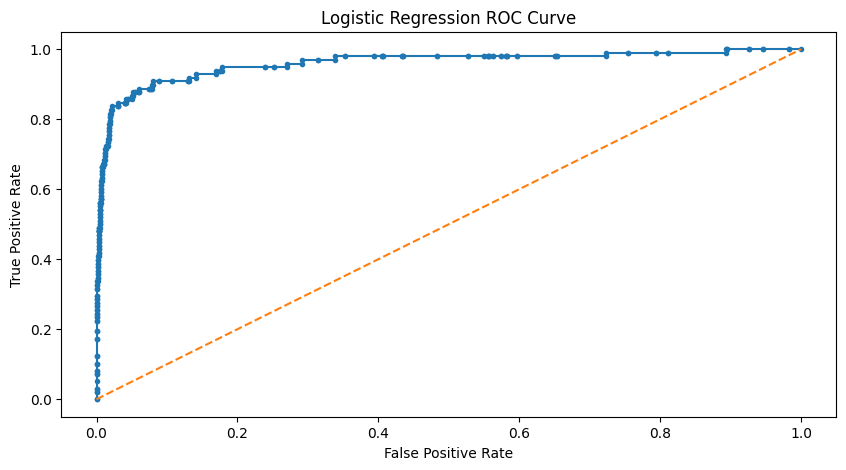

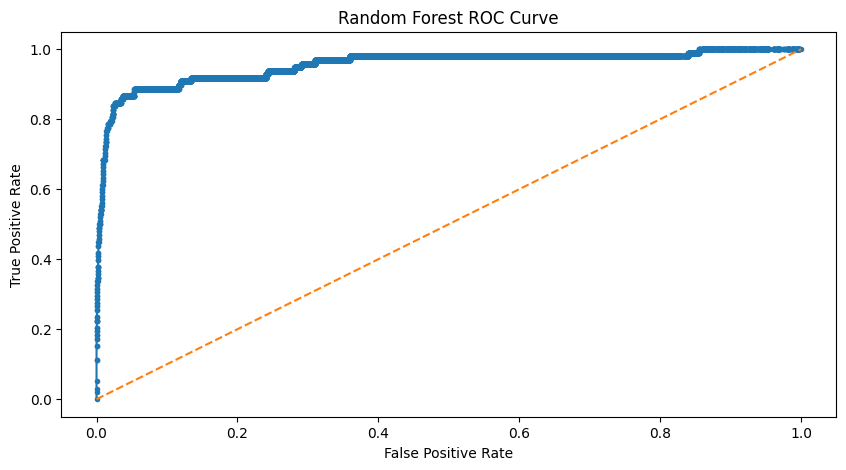

In [20]:
# Visualisation
plot_roc_curve(y_test, log_prob, "Logistic Regression")
plot_roc_curve(y_test, rf_prob, "Random Forest")

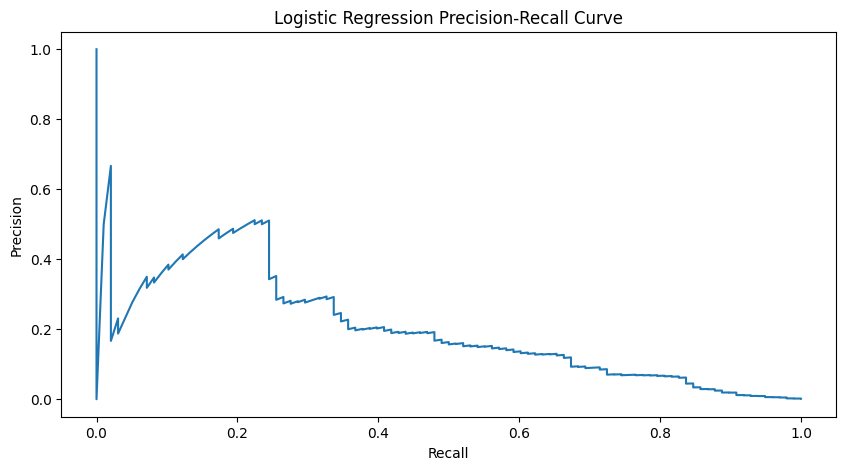

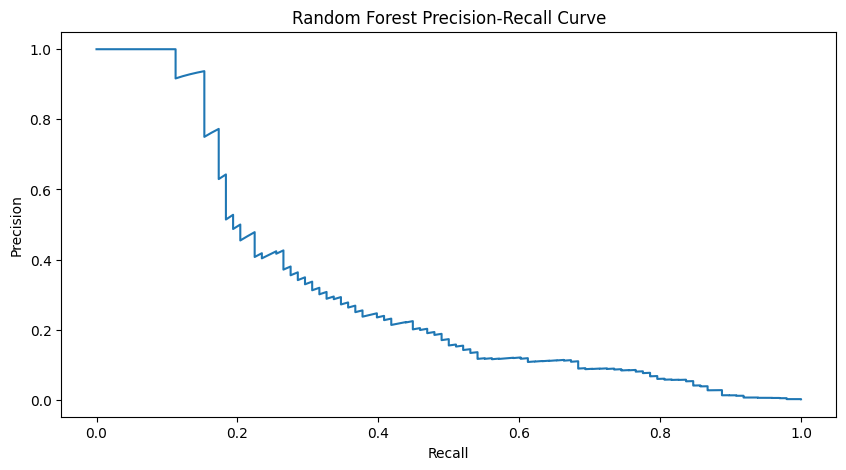

In [22]:
plot_pr_curve(y_test, log_prob, "Logistic Regression")
plot_pr_curve(y_test, rf_prob, "Random Forest")

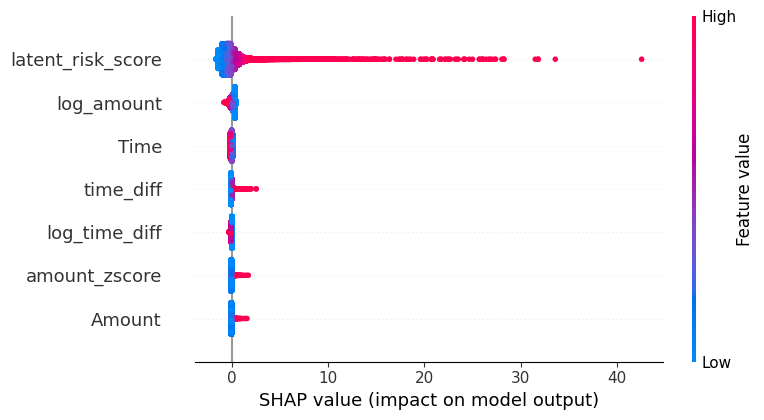

.values =
array([[-1.27687657e-01,  2.58942565e-02, -6.47009803e-02, ...,
        -3.13354934e-01,  2.81515951e-02, -4.72342191e-01],
       [ 1.25351330e-01, -1.39303883e-02,  3.63943014e-02, ...,
         1.03297772e-01, -1.51447735e-02,  1.81707946e+00],
       [ 2.38285427e-03, -5.86625871e-03,  3.63943014e-02, ...,
        -1.26658184e-01, -6.37765133e-03,  3.29042347e+00],
       ...,
       [-1.37222881e-01, -1.33602988e-02,  3.63943014e-02, ...,
         6.44596134e-02, -1.45249863e-02, -1.49401577e-01],
       [-1.33126865e-01, -9.11350863e-03, -6.47009803e-02, ...,
        -7.41837016e-02, -9.90798111e-03, -3.34097039e-01],
       [ 6.93018105e-02, -7.89673169e-03,  3.63943014e-02, ...,
        -9.64297933e-02, -8.58513132e-03, -2.99226368e-01]])

.base_values =
array([-1.73739454, -1.73739454, -1.73739454, ..., -1.73739454,
       -1.73739454, -1.73739454])

.data =
array([[ 1.3871815 ,  0.96504533,  0.        , ...,  5.79909265,
         0.96213928,  0.56757756],
       [-1

In [23]:
shap_explain(log_model, X_test_scaled)

100%|===================| 113909/113924 [79:16<00:00]       

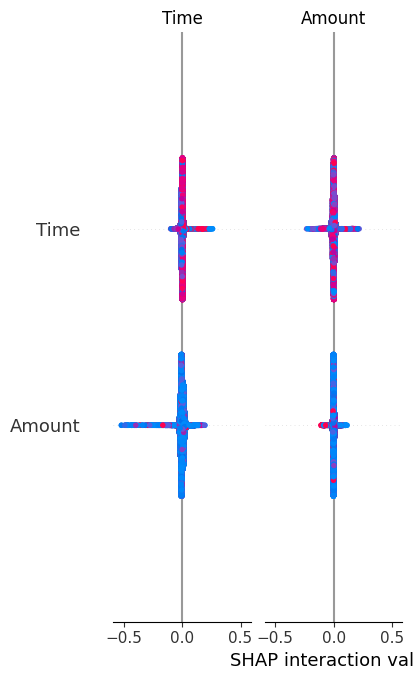

.values =
array([[[ 6.37556628e-03, -6.37556582e-03],
        [-5.26777360e-03,  5.26777413e-03],
        [ 2.91344582e-04, -2.91344499e-04],
        ...,
        [-1.08324302e-02,  1.08324304e-02],
        [-1.23632815e-02,  1.23632821e-02],
        [ 1.02511400e-02, -1.02511396e-02]],

       [[ 1.86210710e-02, -1.86210709e-02],
        [ 6.95063801e-03, -6.95063798e-03],
        [-6.96926723e-04,  6.96926682e-04],
        ...,
        [ 8.57836398e-03, -8.57836390e-03],
        [ 5.04299473e-03, -5.04299451e-03],
        [-2.16477504e-02,  2.16477506e-02]],

       [[-4.36762111e-02,  4.36762104e-02],
        [-3.16364916e-02,  3.16364907e-02],
        [-3.99708497e-03,  3.99708496e-03],
        ...,
        [-3.68847132e-02,  3.68847124e-02],
        [-3.72225644e-02,  3.72225634e-02],
        [-5.45060293e-01,  5.45060281e-01]],

       ...,

       [[ 5.72017645e-03, -5.72017651e-03],
        [-8.37048536e-05,  8.37047715e-05],
        [-1.83280676e-03,  1.83280683e-03],
        

In [26]:
shap_explain(rf_model, X_test_scaled)

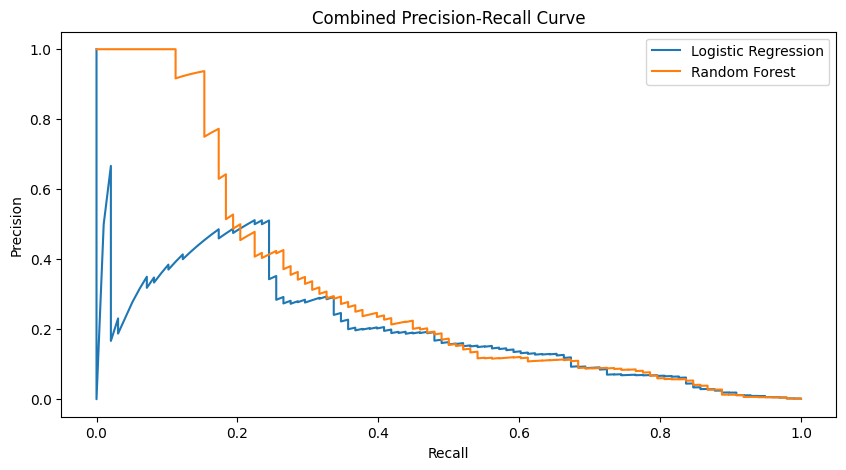

In [24]:
# Combined Precision Recall Curve
prob_combined= {
    "Logistic Regression": log_prob,
    "Random Forest": rf_prob
}

combined_pr_curve(y_test, prob_combined)

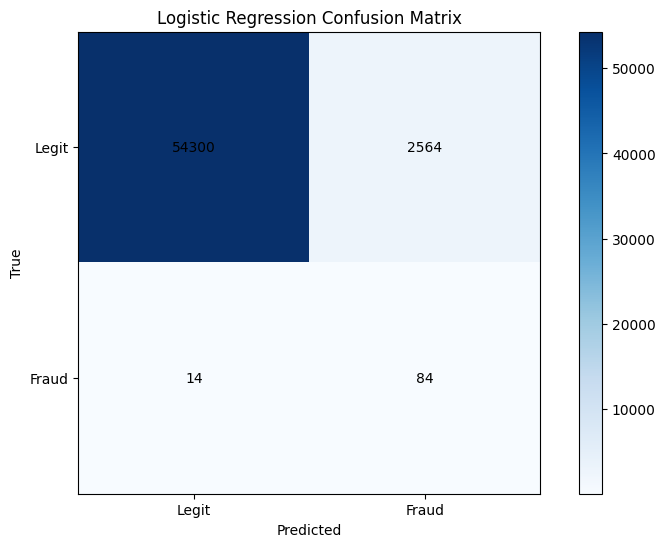

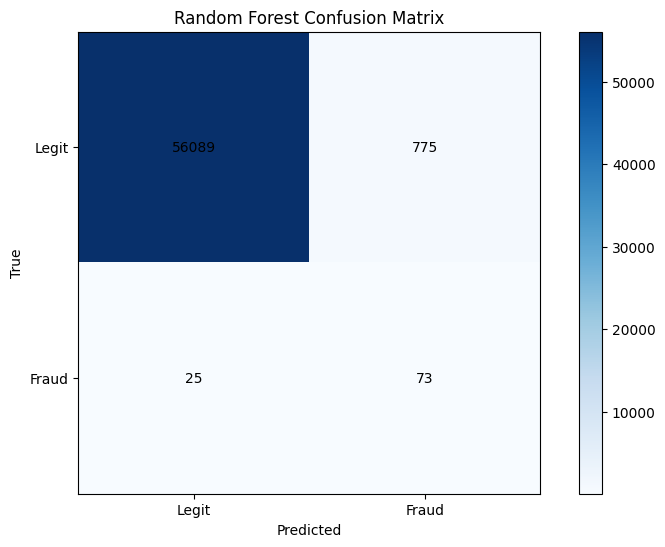

In [25]:
log_pred= (log_prob > 0.5).astype(int)
rf_pred= (rf_prob > 0.5).astype(int)

plot_cm(y_test, log_pred, "Logistic Regression Confusion Matrix")
plot_cm(y_test, rf_pred, "Random Forest Confusion Matrix")